In [95]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd




# Manually specify the path to the directory containing plot_utility.py
util_path = '/home/austin/Drone_AFRL/util'

# Add the directory to the Python path
sys.path.append(util_path)

# import the function we want from that file
from plot_utility import plot_tme

# Define the file path
file_path = '/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py'
file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'
file_path_trajectory = '/home/austin/Drone_AFRL/trajectory_maker.py'

# Define the module name
module_name = 'MPC_DRONE'
EKF_Module = 'ekf'
trajectory_module = 'trajectory_maker'

# Load the module
spec = importlib.util.spec_from_file_location(module_name, file_path)
MPCD = importlib.util.module_from_spec(spec)
sys.modules[module_name] = MPCD
spec.loader.exec_module(MPCD)

# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

# Load the trajectory module
spec_trajectory = importlib.util.spec_from_file_location(trajectory_module, file_path_trajectory)
trajectory = importlib.util.module_from_spec(spec_trajectory)
sys.modules[trajectory_module] = trajectory
spec_trajectory.loader.exec_module(trajectory)


MPC_DRONE_WITH_WIND.py imported successfully!
ekf.py loaded successfully


# Setting up params

In [96]:
TIME=4
dt=0.1
T_length=int(TIME/dt)
t = np.linspace(0,T_length*dt,T_length)

m  = 1.0 # [kg] mass
l  = 0.4 # [m] length
Ix = 1.0 # [kg*m^2] moment of inertia
Iy = 1.0 # [kg*m^2] moment of inertia
Iz = 1.0 # [kg*m^2] moment of inertia
Jr = 1.0 # [kg*m^2] polar moment of inertia
b  = 1.0 # thrust coefficient
d  = 1.0 # drag coefficient
Dl = 2.0 # drag coefficient from ground speed
Dr = 2.0 # drag coefficient from rotation speed

########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iy  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iz  = 2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Jr  = 2*(Real_M*Real_r**2)/5 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.1 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.1 # drag coefficient from rotation speed

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

Real Drone Parameters:
Real_m:        0.086
Real_M:        2.529
Real_M_total:  2.8729999999999998
Real_l:        0.2032
Real_r:        0.1778
Real_Ix:       0.039081470224
Real_Iy:       0.039081470224
Real_Iz:       0.046183391504
Real_Jr:       0.031979548944
Real_b:        1.8311
Real_d:        0.01
Real_Dl:       0.1
Real_Dr:       0.1


Keys for constant velocity trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])
Keys for acceleration trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])
Keys for turning trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])


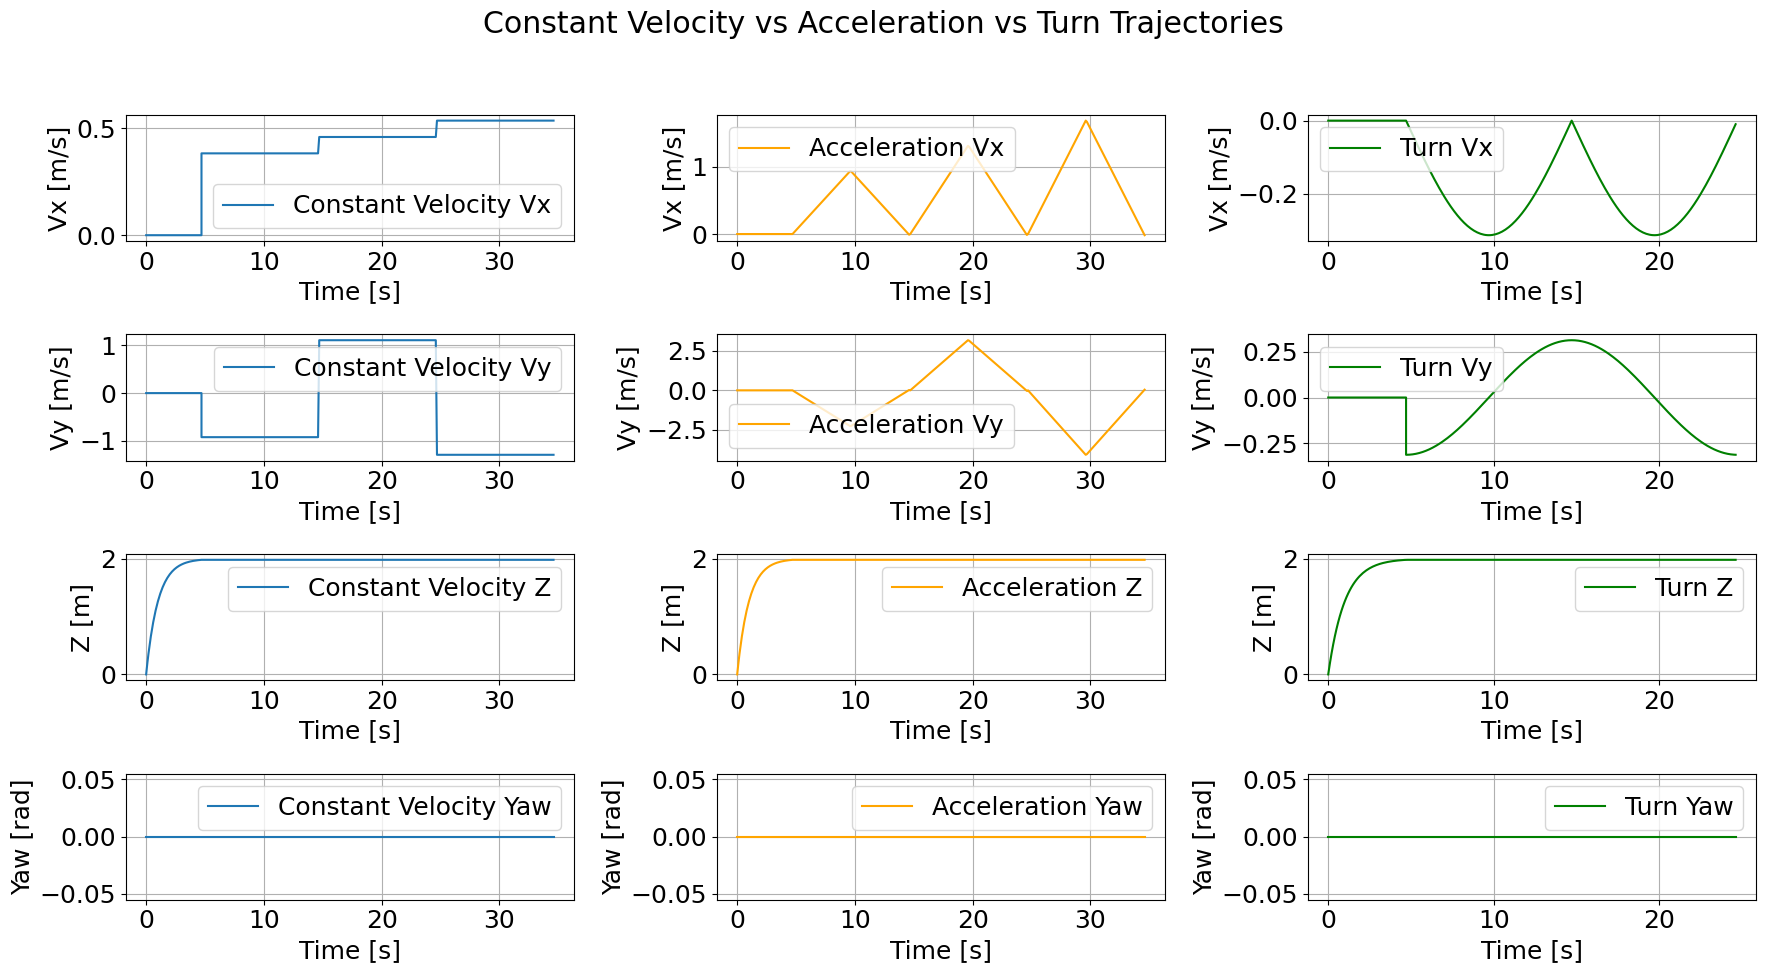

In [98]:
# Create an instance of TrajectoryGenerator with heading enabled for constant velocity
traj_constant_vel = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate a constant velocity profile and concatenate it with the takeoff trajectory
traj_constant_vel.get_constant_vel(V_mag=1.0, T=10, N=3, Step_V=True)

# Retrieve the full trajectory for constant velocity
full_trajectory_constant_vel = traj_constant_vel.get_full_trajectory()

# Create another instance of TrajectoryGenerator for acceleration profile
traj_acc = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate an acceleration profile and concatenate it with the takeoff trajectory
traj_acc.get_Acc(Acc=0.5, T=10, N=3, Step_V=True)

# Retrieve the full trajectory for acceleration
full_trajectory_acc = traj_acc.get_full_trajectory()

# Create another instance of TrajectoryGenerator for turn trajectory
traj_turn = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate a turn trajectory and concatenate it with the takeoff trajectory
traj_turn.get_Turns(r=1.0, T=10, N=2, R_step=False, arc_length=np.pi)

# Retrieve the full trajectory for the turn
full_trajectory_turn = traj_turn.get_full_trajectory()

# Print the keys for verification (optional)
print("Keys for constant velocity trajectory:", full_trajectory_constant_vel.keys())
print("Keys for acceleration trajectory:", full_trajectory_acc.keys())
print("Keys for turning trajectory:", full_trajectory_turn.keys())

# Plot the results: 4 plots for constant velocity on the left column, 4 plots for acceleration in the middle column, 4 plots for turns on the right column
plt.figure(figsize=(18, 10))
plt.suptitle('Constant Velocity vs Acceleration vs Turn Trajectories')

# Constant Velocity Vx
plt.subplot(4, 3, 1)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Vx'], label="Constant Velocity Vx")
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Acceleration Vx
plt.subplot(4, 3, 2)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Vx'], label="Acceleration Vx", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Turn Vx
plt.subplot(4, 3, 3)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Vx'], label="Turn Vx", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Constant Velocity Vy
plt.subplot(4, 3, 4)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Vy'], label="Constant Velocity Vy")
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Acceleration Vy
plt.subplot(4, 3, 5)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Vy'], label="Acceleration Vy", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Turn Vy
plt.subplot(4, 3, 6)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Vy'], label="Turn Vy", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Constant Velocity Z
plt.subplot(4, 3, 7)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Z'], label="Constant Velocity Z")
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Acceleration Z
plt.subplot(4, 3, 8)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Z'], label="Acceleration Z", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Turn Z
plt.subplot(4, 3, 9)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Z'], label="Turn Z", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Constant Velocity Yaw (PSI)
plt.subplot(4, 3, 10)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['PSI'], label="Constant Velocity Yaw")
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

# Acceleration Yaw (PSI)
plt.subplot(4, 3, 11)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['PSI'], label="Acceleration Yaw", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

# Turn Yaw (PSI)
plt.subplot(4, 3, 12)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['PSI'], label="Turn Yaw", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the main title
plt.show()

# Use MPC to get U

## for constant velocity

In [99]:
vx_CV=full_trajectory_constant_vel['Vx']
vy_CV=full_trajectory_constant_vel['Vy']
vz_CV=full_trajectory_constant_vel['Vz']
psi_CV=full_trajectory_constant_vel['PSI']
z_CV=full_trajectory_constant_vel['Z']
wx_CV=full_trajectory_constant_vel['Wx']
wy_CV=full_trajectory_constant_vel['Wy']
wz_CV=full_trajectory_constant_vel['Wz']


## for acc

In [100]:
vx_ACC=full_trajectory_acc['Vx']
vy_ACC=full_trajectory_acc['Vy']
vz_ACC=full_trajectory_acc['Vz']
psi_ACC=full_trajectory_acc['PSI']
z_ACC=full_trajectory_acc['Z']
wx_ACC=full_trajectory_acc['Wx']
wy_ACC=full_trajectory_acc['Wy']
wz_ACC=full_trajectory_acc['Wz']


## for turning

In [101]:
vx_TURN=full_trajectory_turn['Vx']
vy_TURN=full_trajectory_turn['Vy']
vz_TURN=full_trajectory_turn['Vz']
psi_TURN=full_trajectory_turn['PSI']
z_TURN=full_trajectory_turn['Z']
wx_TURN=full_trajectory_turn['Wx']
wy_TURN=full_trajectory_turn['Wy']
wz_TURN=full_trajectory_turn['Wz']


In [102]:
# add user input for if they want constant velocity, acceleration, or turn
T_type = input("Enter 'cv' for constant velocity, 'acc' for acceleration, or 'turn' for turn: ")
if T_type == 'cv':
    vx=copy.deepcopy(vx_CV)
    vy=copy.deepcopy(vy_CV)
    vz=copy.deepcopy(vz_CV)
    psi=copy.deepcopy(psi_CV)
    z=copy.deepcopy(z_CV)
    wx=copy.deepcopy(wx_CV)
    wy=copy.deepcopy(wy_CV)
    wz=copy.deepcopy(wz_CV)
    print('Constant Velocity Trajectory Selected')
elif T_type == 'acc':
    vx=copy.deepcopy(vx_ACC)
    vy=copy.deepcopy(vy_ACC)
    vz=copy.deepcopy(vz_ACC)
    psi=copy.deepcopy(psi_ACC)
    z=copy.deepcopy(z_ACC)
    wx=copy.deepcopy(wx_ACC)
    wy=copy.deepcopy(wy_ACC)
    wz=copy.deepcopy(wz_ACC)
    print('Acceleration Trajectory Selected')
elif T_type == 'turn':
    vx=copy.deepcopy(vx_TURN)
    vy=copy.deepcopy(vy_TURN)
    vz=copy.deepcopy(vz_TURN)
    psi=copy.deepcopy(psi_TURN)
    z=copy.deepcopy(z_TURN)
    wx=copy.deepcopy(wx_TURN)
    wy=copy.deepcopy(wy_TURN)
    wz=copy.deepcopy(wz_TURN)
    print('Turn Trajectory Selected')

mpc = MPCD.MpcDrone(vx=vx,vy=vy,vz=vz,z=z,wx=wx,wy=wy,wz=wz,psi=psi,params=params,dt=dt, n_horizon=50, r_weight=0.1)
X_MPC,U_MPC = mpc.get_X_and_U()
type(X_MPC)

Turn Trajectory Selected
uwix: 0.0
uwiy: 0.0
uwiz: 0.0


numpy.ndarray

# Plot everything from MPC

/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:654: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
2024-09-23 18:42:31,489 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


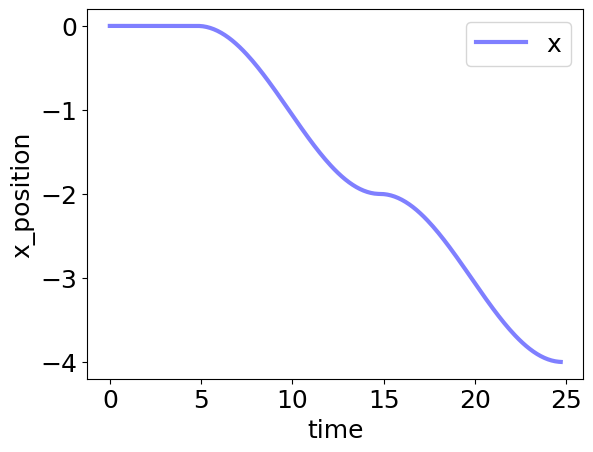

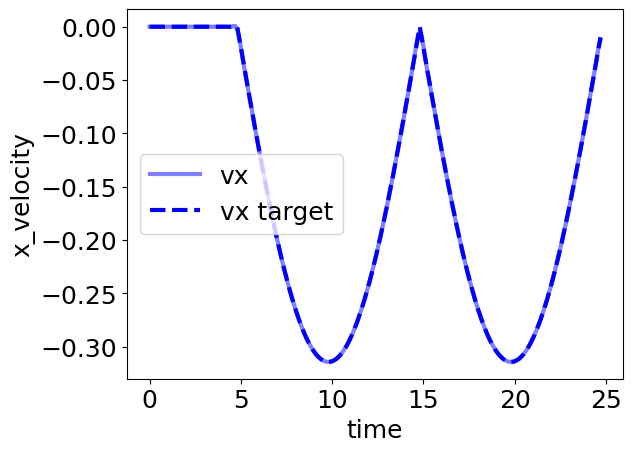

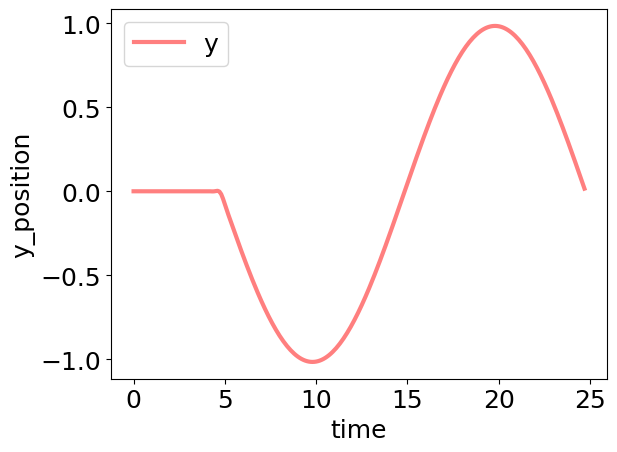

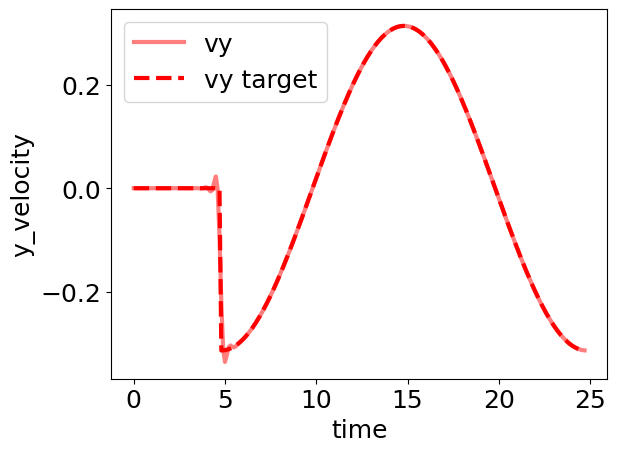

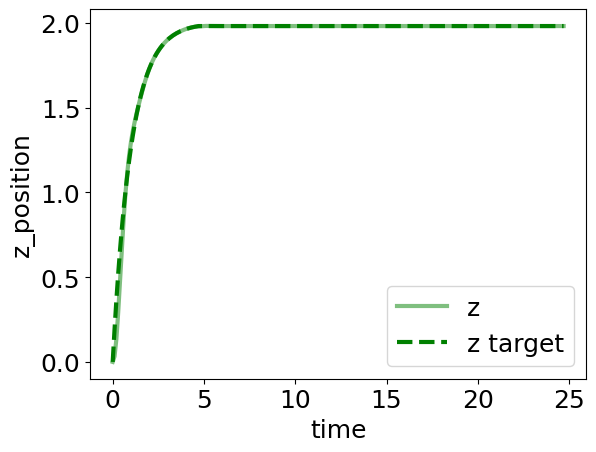

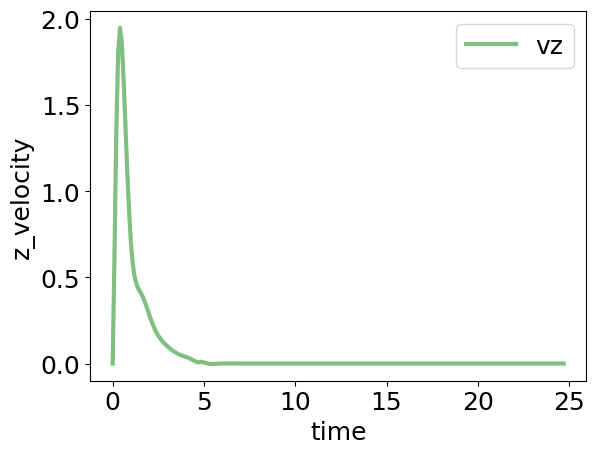

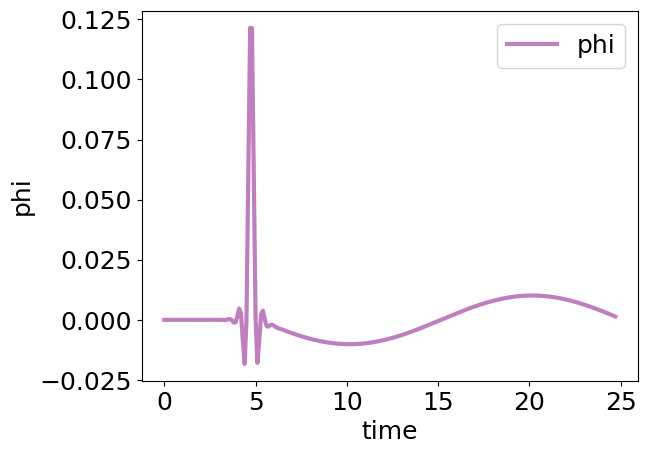

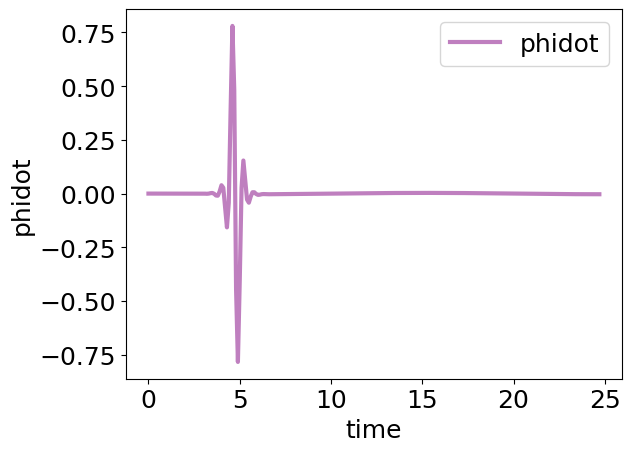

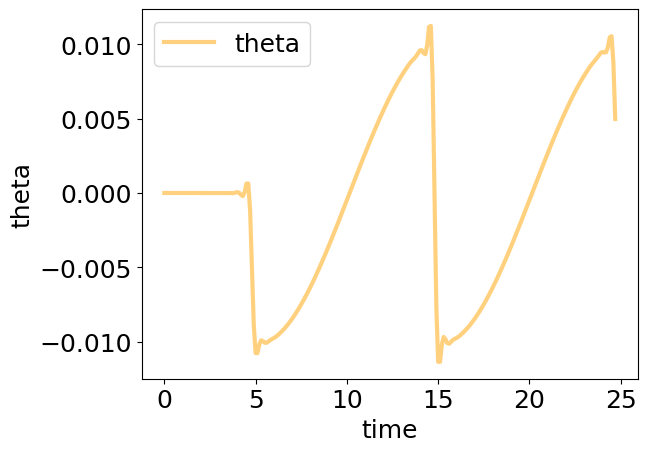

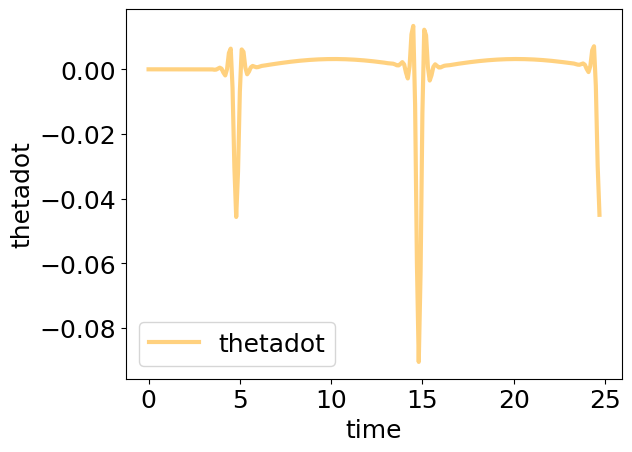

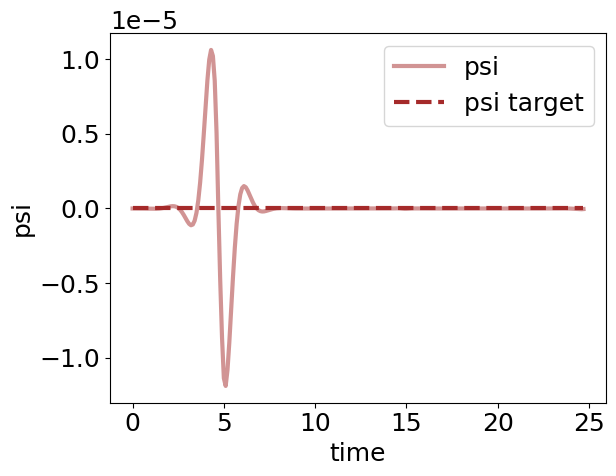

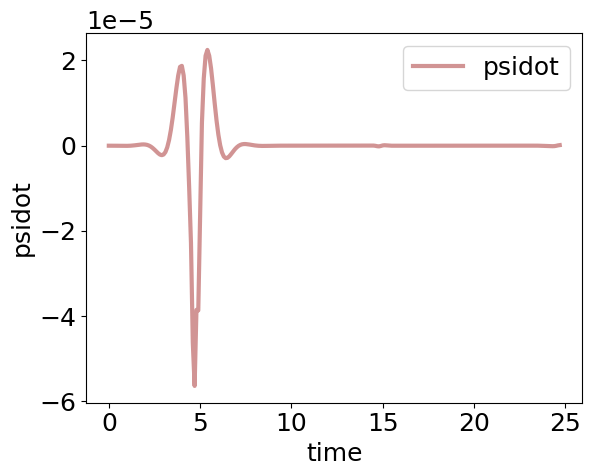

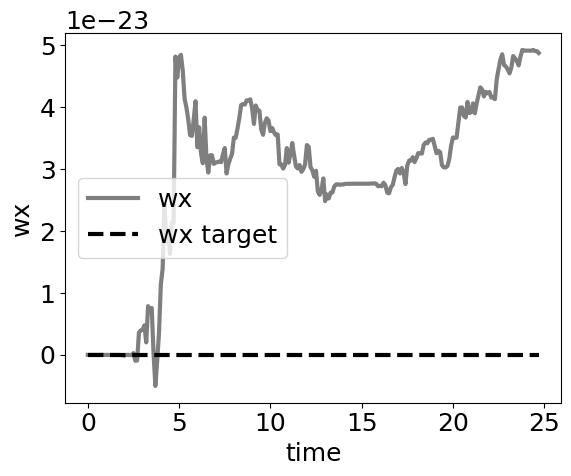

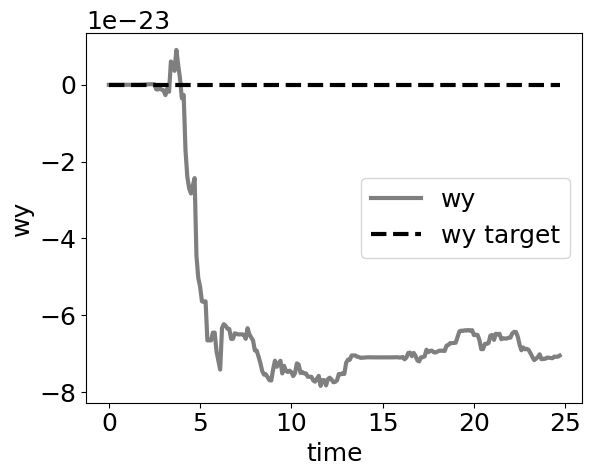

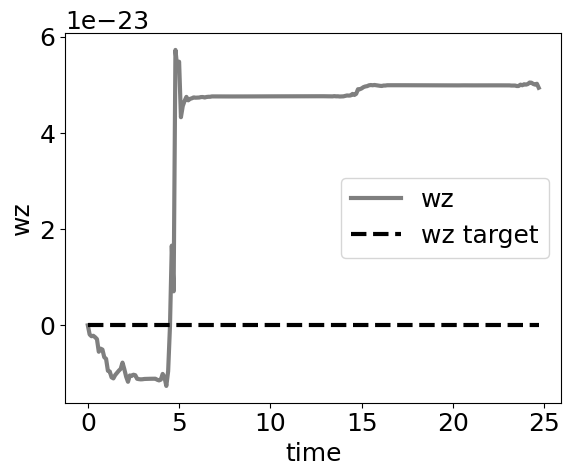

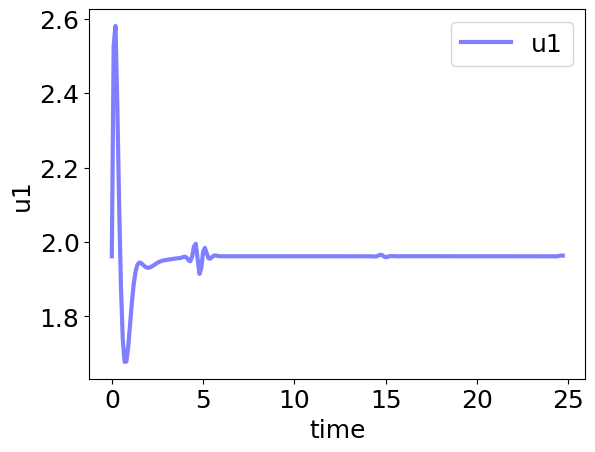

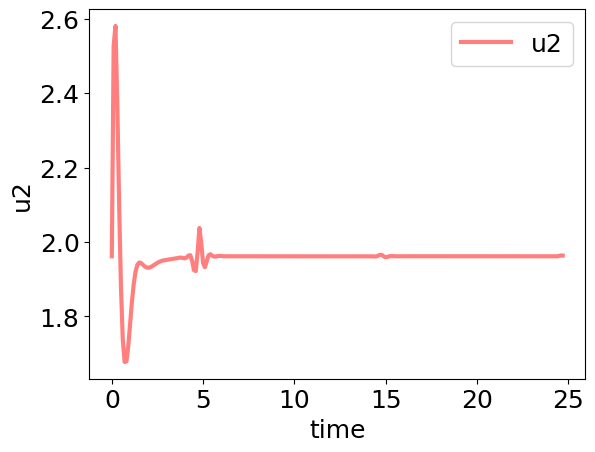

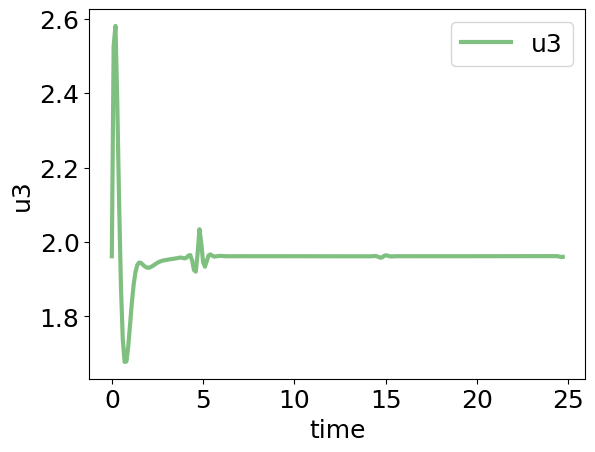

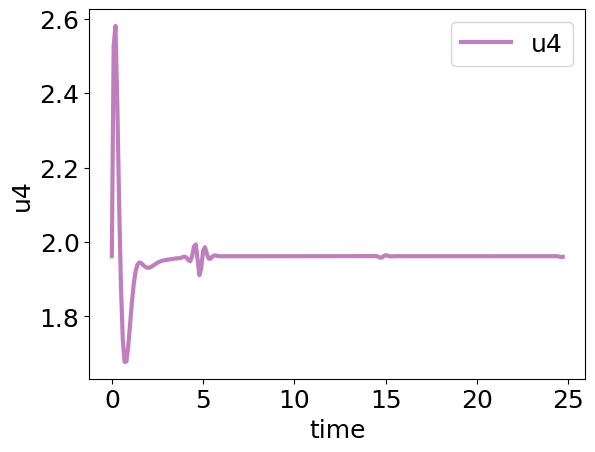

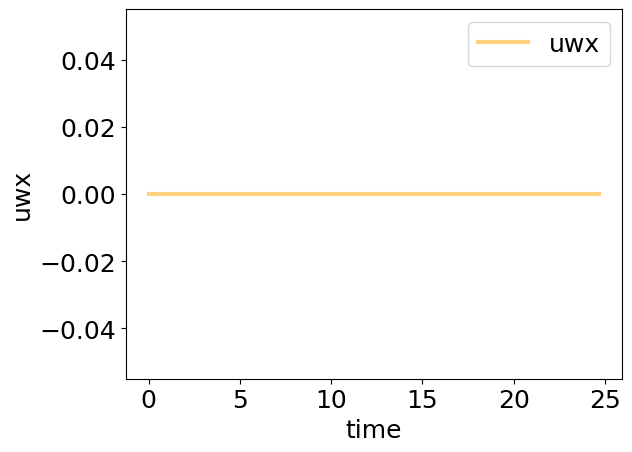

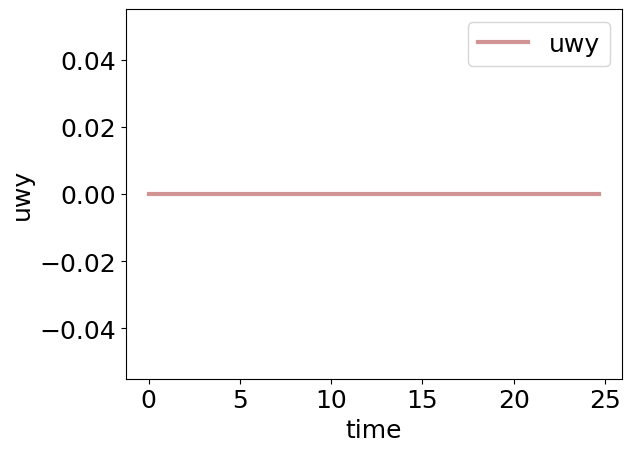

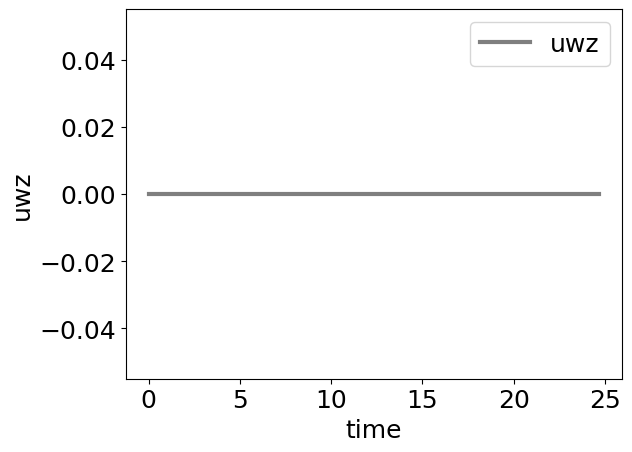

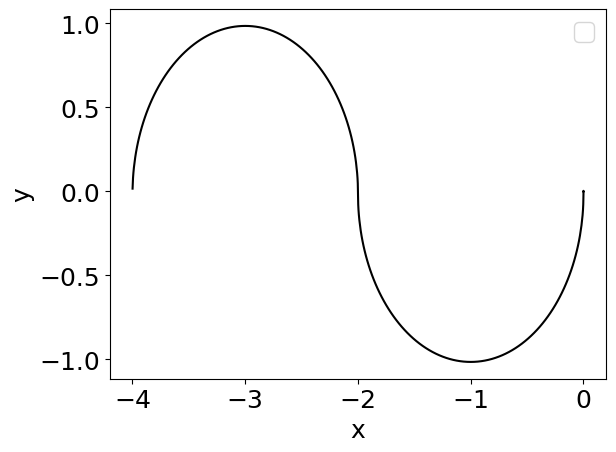

<Figure size 640x480 with 0 Axes>

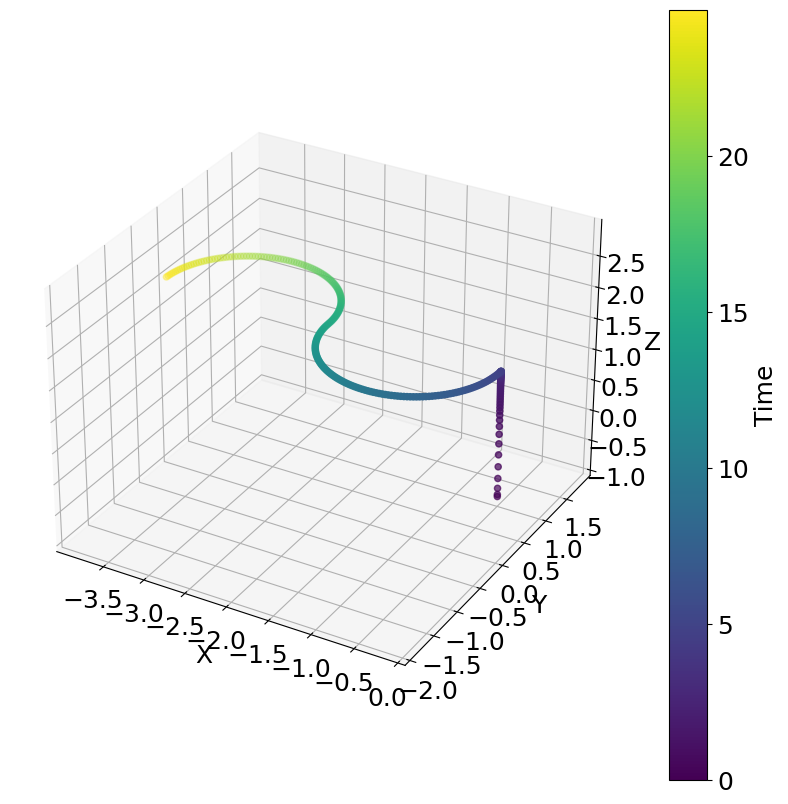

In [103]:
mpc.plot_states_targets_inputs()

# Get measuerments by just running the simulator
## [Px,Vx,Py,Vy,Pz,Vz, ... 
## R,dR,P,dP,Yaw,dYaw, ... 
## Wx,Wy,Wz,OFx,OFy,OFz,Ax,Ay,Az,acc_x,acc_y,acc_z]

In [104]:
M=mpc.run_just_simulator(M=['dR','dP','dYaw','OFx','OFy','OFz','Ax','Ay','Az','acc_x','acc_y','acc_z'])

/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:477: RuntimeWarning: invalid value encountered in divide
  measurements[:, 15] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 1] / self.xsim[:, 4], 0.0)  # OFx = Vx / Pz
/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:478: RuntimeWarning: invalid value encountered in divide
  measurements[:, 16] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 3] / self.xsim[:, 4], 0.0)  # OFy = Vy / Pz
/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:479: RuntimeWarning: invalid value encountered in divide
  measurements[:, 17] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 5] / self.xsim[:, 4], 0.0)  # OFz = Vz / Pz


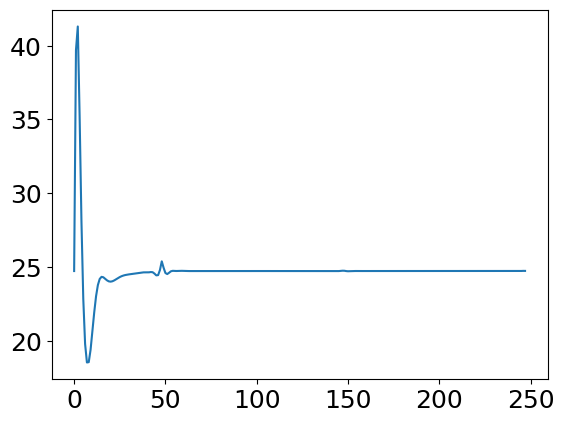

In [105]:
XXX,UUU=mpc.get_X_and_U()
# print(UUU.T[0])

U1=(UUU.T[0]**2+UUU.T[1]**2+UUU.T[2]**2+UUU.T[3])*Real_b

plt.plot(U1)